In [19]:
# !wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
# !unzip nature_12K.zip

In [169]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [3]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [170]:
model = models.inception_v3(weights=None, init_weights=False)

In [171]:
model = model.to(device)

In [173]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)

In [174]:
model = torch.load("inceptionv3.pt",  map_location=device)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [20]:
class CNN(nn.Module):
    def __init__(
        self,
        input_dimension:tuple,
        number_of_filters: int,
        filter_size: tuple,
        stride: int,
        padding: int,
        max_pooling_size: tuple,
        n_neurons: int,
        n_classes: int,
        conv_activation: nn.Module,
        dense_activation: nn.Module,
        dropout_rate:float,
        use_batchnorm:bool,
        factor:float,
        dropout_organisation:int
    ):
        super().__init__()
        self.conv_blocks = nn.ModuleList([])
        in_c = input_dimension[0]
        for i in range(0, 5):
            add_dropout = i%dropout_organisation > 0
            out_c = int((factor**i)*number_of_filters)
            if out_c<=0:
                out_c = 3
            conv_block = self.create_conv_block(in_c, out_c, filter_size, max_pooling_size, stride, padding, conv_activation, dropout_rate, use_batchnorm, add_dropout)
            self.conv_blocks.append(conv_block)
            in_c = out_c

        self.flatten = nn.Flatten()

        r = torch.ones(1, *input_dimension)
        for block in self.conv_blocks:
            block.eval()
            r = block(r)
        in_features = int(np.prod(r.size()[1:]))

        self.dense_block1 = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_neurons),
            dense_activation,
            nn.Linear(in_features=n_neurons, out_features=n_classes)
        )

    def create_conv_block(self, in_c, out_c, kernel_size, max_pooling_size, stride, padding, conv_activation, dropout_rate, use_batchnorm, add_dropout):
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
            conv_activation,
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.MaxPool2d(kernel_size=max_pooling_size))
        if add_dropout:
            layers.append(nn.Dropout(p=dropout_rate))
        return nn.Sequential(*layers)


    def __call__(self, x):
        r = x
        for block in self.conv_blocks:
            r = block(r)
        r = self.flatten(r)
        output = self.dense_block1(r)
        return output

In [9]:
test_data_path = "inaturalist_12K/val/"

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                            inplace=False),
])

In [11]:
test_data = ImageFolder(root=test_data_path, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [28]:
classes = test_dataloader.dataset.classes

In [21]:
config = {
    'number_of_filters': 32,
    'filter_size': 3,
    'stride': 1,
    'padding': 1,
    'max_pooling_size': 2,
    'n_neurons': 512,
    'n_classes': 10,
    'conv_activation': 'relu',
    'dense_activation': 'relu',
    'dropout_rate': 0.2,
    'use_batchnorm': True,
    'factor':1,
    'learning_rate': 1e-5,
    'batch_size':64,
    'epochs':100,
    'use_augmentation': False,
    'dropout_organisation': 3,
    'weight_decay':1e-2
}

In [25]:
model = CNN(
      input_dimension=(3,224,224),
        number_of_filters=config['number_of_filters'],
        filter_size =(config['filter_size'],config['filter_size']),
        stride=config['stride'],
        padding=config['padding'],
        max_pooling_size=(config['max_pooling_size'],config['max_pooling_size']),
        n_neurons=config['n_neurons'],
        n_classes=config['n_classes'],
        conv_activation=nn.ReLU(),
        dense_activation=nn.ReLU(),
        dropout_rate=config['dropout_rate'],
        use_batchnorm=config['use_batchnorm'],
        factor=config['factor'],
        dropout_organisation=config['dropout_organisation']
    ).to(device)

In [26]:
model = torch.load("custom_cnn.pt",  map_location=device)

In [27]:
model.eval()

CNN(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1-2): 2 x Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)

In [30]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        (inputs, labels) = (inputs.to(device), labels.to(device))
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [33]:
# Count the number of correct predictions
correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
# Calculate the accuracy
accuracy = correct_predictions / len(y_true)
print("Overall accuracy:", accuracy)

Overall accuracy: 0.3495


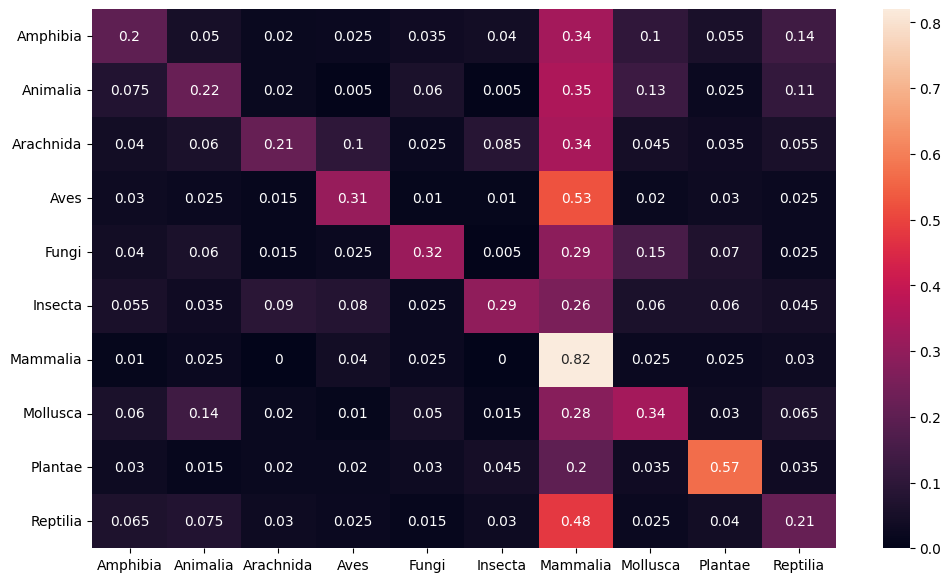

In [31]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [98]:
# Assuming testloader contains the test data loader
# You can iterate through the test loader to get the images and labels
images = []
true_labels = []
predicted_labels = []

# iterate over test data
for inputs, labels in test_dataloader:
    (inputs, labels) = (inputs.to(device), labels.to(device))
    output = model(inputs) # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()

    images.extend(inputs) # Save images
    true_labels.extend(labels.data.cpu().numpy()) # Save true labels
    predicted_labels.extend(output) # Save predicted labels

In [167]:
def display_images(images, true_labels, predicted_labels, num_classes=10):
    fig, axs = plt.subplots(num_classes, 3, figsize=(15, 40))
    for i in range(num_classes):
        fig.text(0.5, (i + 0.5) / num_classes, classes[i], ha='center', va='center', fontsize=18)
        class_indices = np.where(np.array(true_labels) == i)[0]
        for j in range(3):
            idx = np.random.choice(class_indices)
            image = images[idx].cpu().numpy().transpose((1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min())
            axs[i, j].imshow(image)
            axs[i, j].set_title(f"True: {classes[true_labels[idx]]}\nPredicted: {classes[predicted_labels[idx]]}", fontsize=10)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        axs[i, 0].set_ylabel(classes[i], fontsize=18)
    plt.tight_layout()

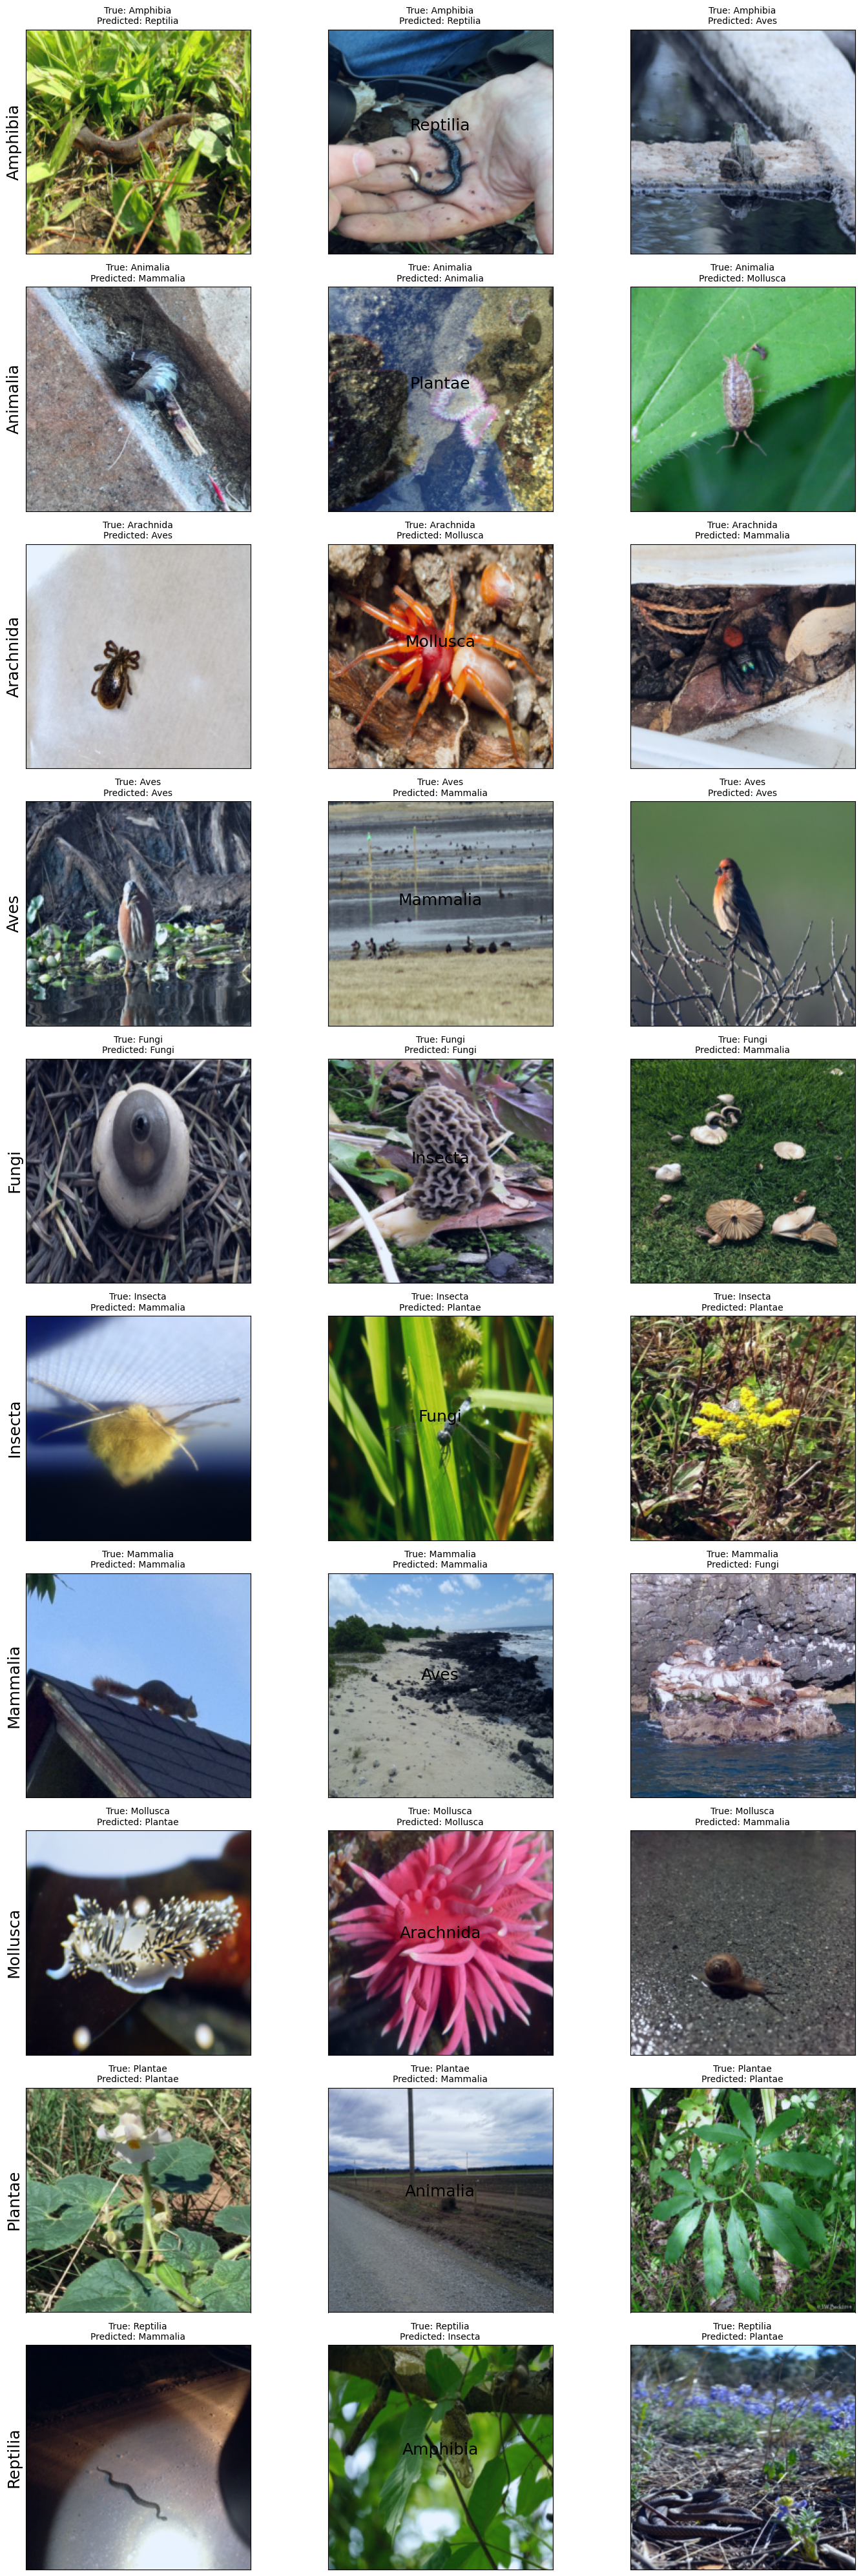

In [168]:
display_images(images, true_labels, predicted_labels)